In [6]:
import keras.backend as K
import numpy as np
from matplotlib import pyplot as plt

def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    """
    Suppose input_dim = 10  time_steps = 6
    formed one  x 6 x 10 The data of each step 6 dimension is the same as y
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y
     

In [7]:
from keras.layers import Input, Dense, LSTM ,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model

#from attention_utils import get_activations
from keras.layers import Multiply
from keras.layers.core import *
from keras.models import *

import  pandas as pd
import  numpy as np

from keras.layers.merging.concatenate import concatenate
from keras.layers.merging.add import add
from keras.layers.merging.multiply import multiply
from keras.layers.merging.subtract import subtract
from keras.layers.merging.average import average
from keras.layers.merging.maximum import maximum
from keras.layers.merging.minimum import minimum
from keras.layers.merging.dot import dot

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

# Another way of writing the attention mechanism is suitable for the use of the above error source:https://blog.csdn.net/uhauha2929/article/details/80733255
def attention_3d_block2(inputs, single_attention_vector=False):
    # If the upper layer is LSTM, you need return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # Multiplied by the attention weight, but there is no summation, it seems to have little effect
    # If you classify tasks, you can do Flatten expansion
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul



def create_dataset(dataset, look_back):
    '''
    Processing the data
    '''
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Multidimensional normalization returns data and maximum and minimum values
def NormalizeMult(data):
    #normalize Used for denormalization
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0,data.shape[1]):
        #Column i
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

# Multidimensional denormalization
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            #Row j
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data


def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(drop)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #For GPU you can use CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(drop)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    #output = Dense(1, activation='sigmoid')(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model
     

In [8]:
data = pd.read_csv("P_2S_700K_1000K.csv")
data

,time,ILB_4,ILA_3,ALC_2,APC_1,ILC_5,Pref_6,VA_7,IA_8,P_9,Q_10,LOOP_11,f_12
0,0.0000,0.443705,0.001250,0.001250,250.000000,0.443717,700000,-0.016808,4.580000e-08,0.000000e+00,0.000000,1,50.000000
1,0.0001,-1.659962,-2.543264,0.101772,249.993304,-1.658923,700000,1030.843271,5.290073e+00,-8.121430e-01,-0.000001,1,50.000000
2,0.0002,-1.313555,-2.190473,3.700415,250.006557,-1.654849,700000,976.218681,1.178178e+01,-6.565481e+00,-12.902376,1,50.000000
3,0.0003,-1.201551,-1.369757,7.394651,250.011283,-1.300003,700000,1004.725363,1.752882e+01,-2.659594e+01,-65.180392,1,50.000000
4,0.0004,-1.210002,-0.774918,10.491840,250.067752,-1.173960,700000,949.412212,2.253352e+01,-7.207645e+01,-183.335950,1,50.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39996,3.9996,60.723815,60.024982,95.943459,236.885594,61.995446,1000000,767.926862,7.183696e+01,1.000024e+06,-4551.035480,1,50.003059
39997,3.9997,61.232459,60.113253,99.799390,237.411499,61.660721,1000000,797.356728,7.937228e+01,1.000031e+06,-4551.660955,1,50.003129
39998,3.9998,61.119873,60.291829,103.564616,237.587967,61.416102,1000000,826.932913,8.654557e+01,1.000039e+06,-4550.669167,1,50.003196
39999,3.9999,60.850079,60.369743,107.477592,238.154917,61.597683,1000000,1025.629709,9.421570e+01,1.000049e+06,-4559.379430,1,50.003261


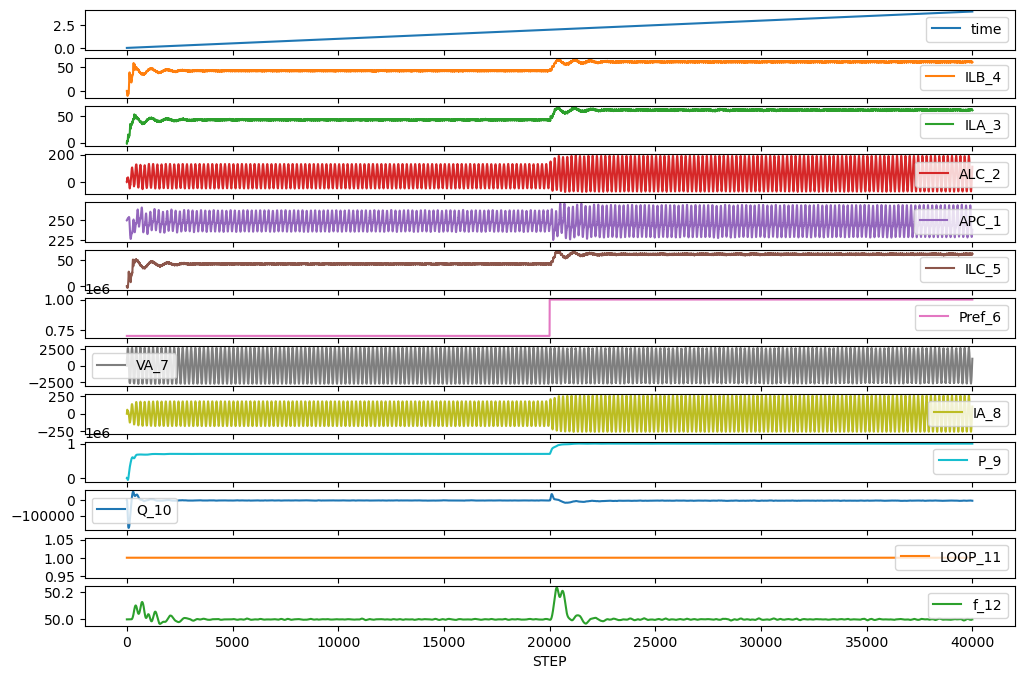

In [9]:
data.plot(legend=True, subplots=True, figsize=(12,8), xlabel="STEP")
plt.show()

In [10]:
data = data.drop(['time'], axis = 1)
print(data.columns)
print(data.shape)

Index(['ILB_4', 'ILA_3', 'ALC_2', 'APC_1', 'ILC_5', 'Pref_6', 'VA_7', 'IA_8',
       'P_9', 'Q_10', 'LOOP_11', 'f_12'],
      dtype='object')
(40001, 12)


### 改各自层数！

In [11]:

INPUT_DIMS = 13
TIME_STEPS = 50
lstm_units = 64
drop = 0

#Normalized
data,normalize = NormalizeMult(data)
pollution_data = data[:,0].reshape(len(data),1)

train_X, _ = create_dataset(data,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)

print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
m.compile(optimizer='adam', loss='mse')
#m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.1)
#m.save("./model.h5")
#np.save("normalize.npy",normalize)

(12, 2)
(39950, 50, 11) (39950, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 13)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 64)       896         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 50, 64)       0           ['conv1d[0][0]']                 
                                                                                                  
 bidirectional (Bidirectional)  (None, 50, 128)      66048       ['dropout[0][0]']                
                                                           

In [12]:

from sklearn.model_selection import train_test_split
df = pd.read_csv("P_2S_700K_1000K.csv")
df = df.drop(['time'], axis = 1)
train_size = int(len(df)*0.9)#数据划分
train = df.iloc[:train_size,:]
test = df.iloc[train_size:,:]
#train, test = train_test_split(df, test_size=0.1)
print("len(train):",len(train))
print("len(test):",len(test))
     

len(train): 36000
len(test): 4001


In [13]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
     

In [14]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_path = './model.h5'
# TRAIN
INPUT_DIMS = 11
TIME_STEPS = 50
lstm_units = 64

#Normalized
train,normalize = NormalizeMult(train)
pollution_data = train[:,0].reshape(len(train),1)

train_X, _ = create_dataset(train,TIME_STEPS)
_ , train_Y = create_dataset(pollution_data,TIME_STEPS)
print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mae', optimizer='adam',metrics=['mae',r2_keras])

# fit the network
history =  m.fit([train_X], train_Y, epochs=30, batch_size=30, validation_split=0.1)
#history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )
     

(12, 2)
(35949, 50, 11) (35949, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 11)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 64)       768         ['input_2[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 50, 64)       0           ['conv1d_1[0][0]']               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 50, 128)     66048       ['dropout_2[0][0]']              
 )                                                       

In [15]:
m.save("./C_L_A.h5")

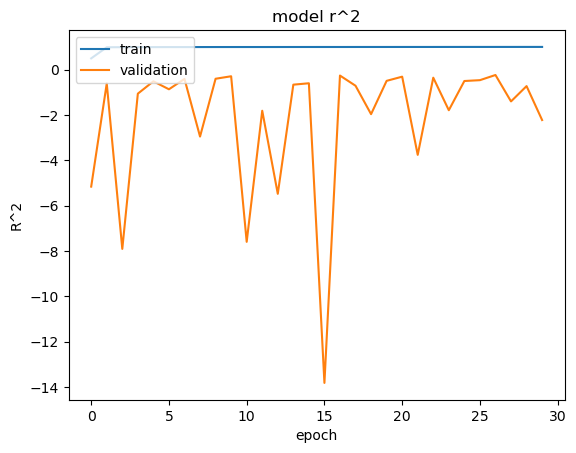

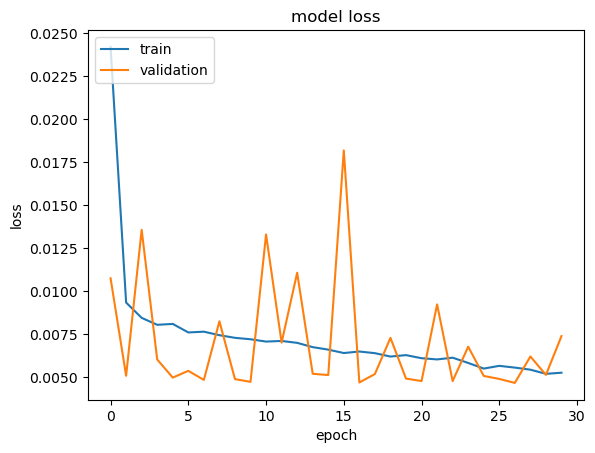

In [16]:
import matplotlib.pyplot as plt

# summarize history for R^2
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
# TEST
train,normalize = NormalizeMult(train)
pollution_test = train[:,0].reshape(len(train),1)

test_X, _ = create_dataset(train,TIME_STEPS)
_ , test_Y = create_dataset(pollution_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)

(12, 2)
(35949, 50, 11) (35949, 1)


In [18]:

# Prediction
scores_test = m.evaluate([test_X], test_Y, verbose=2)

1124/1124 - 9s - loss: 0.0064 - mae: 0.0064 - r2_keras: -1.3454e+00 - 9s/epoch - 8ms/step


In [19]:
results = m.predict([test_X])

1124/1124 [==============================] - 9s 8ms/step


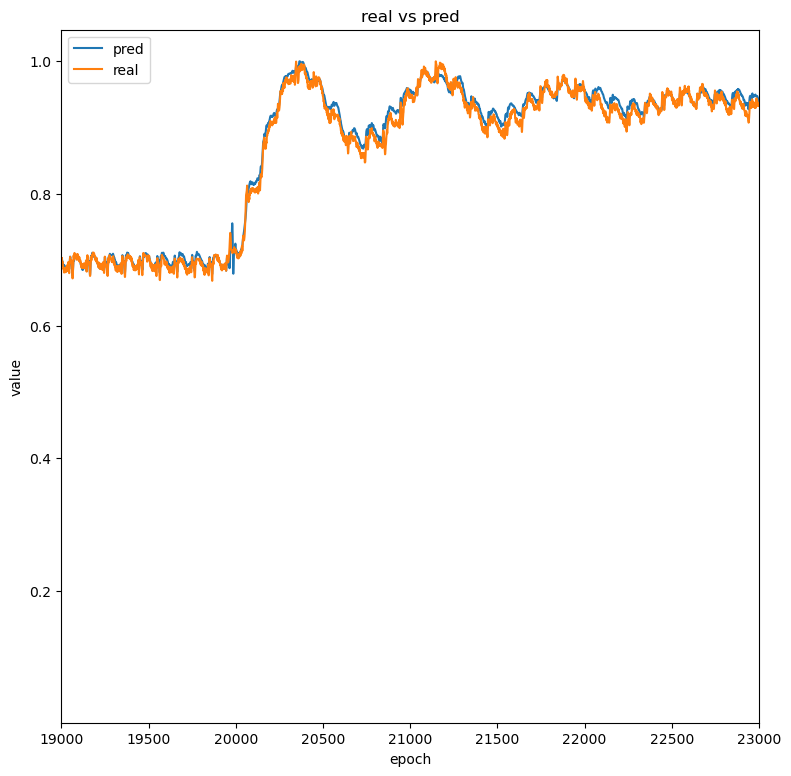

In [20]:

fig_acc = plt.figure(figsize=(9, 9))
plt.plot(results[0:27000])
plt.plot(test_Y[0:27000])
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('epoch')
plt.xlim((19000, 23000))
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [21]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

print('以下是CNN_biLSTM_Attention误差')
print('R^2决定系数：',r2_score(test_Y[000:14000],results[00:14000]))
print('RMSE为：',np.sqrt(mean_squared_error(test_Y[2500:18000],results[2500:18000])))
print('MAPE为：',(abs(results[9000:15000] -test_Y[9000:15000])/ test_Y[9000:15000]).mean())

以下是CNN_biLSTM_Attention误差
R^2决定系数： 0.9779385664109004
RMSE为： 0.005917735257223756
MAPE为： 0.0070321039353948124


In [22]:
test_new=[]
predict_new=[] 

for k in range(len(results)):
    if test_Y[k]!=0:
        test_new.append(test_Y[k])
        predict_new.append(results[k])

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.fabs((y_true - y_pred) / y_true))
mape = format(MAPE(test_new, predict_new), '.4f') 
mape

'0.0081'